# Démo cours LLMs & transformers

In [1]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModel, pipeline
from gensim.models import Word2Vec
import numpy as np

## Démonstration : embeddings statiques vs embeddings contextuels

Le code suivant illustre la différence fondamentale entre les représentations de mots (*word embeddings*) **statiques** et **contextuelles**. Avec un modèle statique comme **Word2Vec**, un mot (ex: "avocat") possède un **unique vecteur**, quelle que soit la phrase. À l'inverse, un modèle moderne comme **CamemBERT** (un Transformer) génère un vecteur **différent** pour "avocat" en fonction du contexte, lui permettant de distinguer le fruit 🥑 du juriste 👨‍⚖️. Le code ci-dessous prouve cette distinction en comparant les vecteurs générés dans deux phrases aux sens opposés.

In [17]:
# Données (deux sens d’"avocat")
s1 = ["j", "aime", "manger", "un", "avocat", "avec", "du", "citron"]   # fruit
s2 = ["je", "vais", "consulter", "mon", "avocat", "pour", "ce", "litige"]  # métier
sentences = [s1, s2]

# ===== A) EMBEDDING STATIQUE (Word2Vec) =====
model = Word2Vec(sentences, vector_size=50, min_count=1, sg=1, epochs=200, workers=1)

v_avocat_1 = model.wv["avocat"]     # vecteur "avocat" (fruit)
v_avocat_2 = model.wv["avocat"]     # vecteur "avocat" (métier) -> même clé, donc même vecteur

def cos(a, b):
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    return float(a @ b / (na * nb)) if na and nb else 0.0

# Vecteurs de phrase (moyenne des mots) pour montrer que les PHRASES, elles, diffèrent
def sent_vec(tokens):
    vecs = [model.wv[w] for w in tokens if w in model.wv.key_to_index]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

sv1, sv2 = sent_vec(s1), sent_vec(s2)

print("=== A) Word2Vec (statique) ===")
print("Dim vecteur 'avocat':", v_avocat_1.shape[0])
print("Extrait 'avocat':", np.round(v_avocat_1[:8], 4))
print("Même vecteur pour les deux contextes ? ->", np.allclose(v_avocat_1, v_avocat_2))
print("Cosinus( 'avocat' fruit, 'avocat' métier ) ->", round(cos(v_avocat_1, v_avocat_2), 4))  # ~ 1.0 (identiques)
print("Cosinus( phrase fruit, phrase métier ) ->", round(cos(sv1, sv2), 4))  # < 1 (phrases différentes)
print()

# ===== B) EMBEDDING CONTEXTUEL (CamemBERT) — OPTIONNEL =====
# Montre que le même mot a des vecteurs différents selon le contexte
# pip install transformers torch sentencepiece  # (si besoin)
try:
    from transformers import AutoTokenizer, AutoModel
    import torch

    tokenizer = AutoTokenizer.from_pretrained("camembert-base")
    model_ctx = AutoModel.from_pretrained("camembert-base")

    def token_embedding_for_avocat(text):
        # tokenize + récupérer l’embedding du token qui correspond à "avocat"
        # On prend l’embedding de la dernière couche (hidden_states[-1]) au centre du sub-token "avocat"
        with torch.no_grad():
            enc = tokenizer(text, return_tensors="pt", add_special_tokens=True, return_offsets_mapping=True)
            outputs = model_ctx(**{k: v for k, v in enc.items() if k in ["input_ids","attention_mask"]}, output_hidden_states=True)
            last_hidden = outputs.hidden_states[-1][0]  # [seq_len, hidden]
            tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

            # Trouver l'index du (des) sub-token(s) "avocat" (CamemBERT découpe en sous-morceaux)
            idxs = [i for i,tok in enumerate(tokens) if "avocat" in tok.replace("▁","")]
            if not idxs:
                return None
            # moyenne des sous-tokens "avocat"
            emb = last_hidden[idxs].mean(dim=0).numpy()
            return emb

    t1 = "J'aime manger un avocat avec du citron."
    t2 = "Je vais consulter mon avocat pour ce litige."

    e1 = token_embedding_for_avocat(t1)
    e2 = token_embedding_for_avocat(t2)

    print("=== B) CamemBERT (contextuel) ===")
    if e1 is not None and e2 is not None:
        print("Dim vecteur 'avocat' (contextuel):", e1.shape[0])
        print("Extrait 'avocat' (fruit):   ", np.round(e1[:16], 4))
        print("Extrait 'avocat' (métier):  ", np.round(e2[:16], 4))
        print("Cosinus( 'avocat' fruit, 'avocat' métier ) ->", round(cos(e1, e2), 4))  # typiquement << 1
    else:
        print("Impossible de localiser 'avocat' dans les sous-tokens (tokenizer).")

except Exception as e:
    print("=== B) CamemBERT (contextuel) ===")
    print("Section optionnelle non exécutée (transformers/torch non installés ou autre).")
    print("Message :", e)


=== A) Word2Vec (statique) ===
Dim vecteur 'avocat': 50
Extrait 'avocat': [-0.0017  0.0007  0.0099  0.018  -0.0192 -0.0152  0.014   0.0179]
Même vecteur pour les deux contextes ? -> True
Cosinus( 'avocat' fruit, 'avocat' métier ) -> 1.0
Cosinus( phrase fruit, phrase métier ) -> 0.4412

=== A) Word2Vec (statique) ===
Dim vecteur 'avocat': 50
Extrait 'avocat': [-0.0017  0.0007  0.0099  0.018  -0.0192 -0.0152  0.014   0.0179]
Même vecteur pour les deux contextes ? -> True
Cosinus( 'avocat' fruit, 'avocat' métier ) -> 1.0
Cosinus( phrase fruit, phrase métier ) -> 0.4412



=== B) CamemBERT (contextuel) ===
Dim vecteur 'avocat' (contextuel): 768
Extrait 'avocat' (fruit):    [-0.0226 -0.1815  0.159  -0.1704 -0.1075  0.1613 -0.0099 -0.0805  0.0881  0.121  -0.249   0.0333  0.0632 -0.0215 -0.1109 -0.0044]
Extrait 'avocat' (métier):   [-0.0236 -0.116   0.3428 -0.0548 -0.0436  0.2107  0.158  -0.0386  0.1081  0.0726 -0.1534  0.1454  0.2406 -0.0148 -0.0683 -0.1107]
Cosinus( 'avocat' fruit, 'avocat' métier ) -> 0.6615
=== B) CamemBERT (contextuel) ===
Dim vecteur 'avocat' (contextuel): 768
Extrait 'avocat' (fruit):    [-0.0226 -0.1815  0.159  -0.1704 -0.1075  0.1613 -0.0099 -0.0805  0.0881  0.121  -0.249   0.0333  0.0632 -0.0215 -0.1109 -0.0044]
Extrait 'avocat' (métier):   [-0.0236 -0.116   0.3428 -0.0548 -0.0436  0.2107  0.158  -0.0386  0.1081  0.0726 -0.1534  0.1454  0.2406 -0.0148 -0.0683 -0.1107]
Cosinus( 'avocat' fruit, 'avocat' métier ) -> 0.6615


## Démo : Visualiser l'Attention 🔦

Pour rendre le mécanisme d'attention concret, prenons la phrase de notre exemple et voyons quels mots le modèle "regarde" pour comprendre le pronom "**il**".

Nous allons utiliser le modèle **CamemBERT** pour extraire ses "scores d'attention" et les afficher. Le code ci-dessous montre, pour le mot "il", le poids (l'intensité du "spotlight") qu'il met sur chaque autre mot de la phrase.

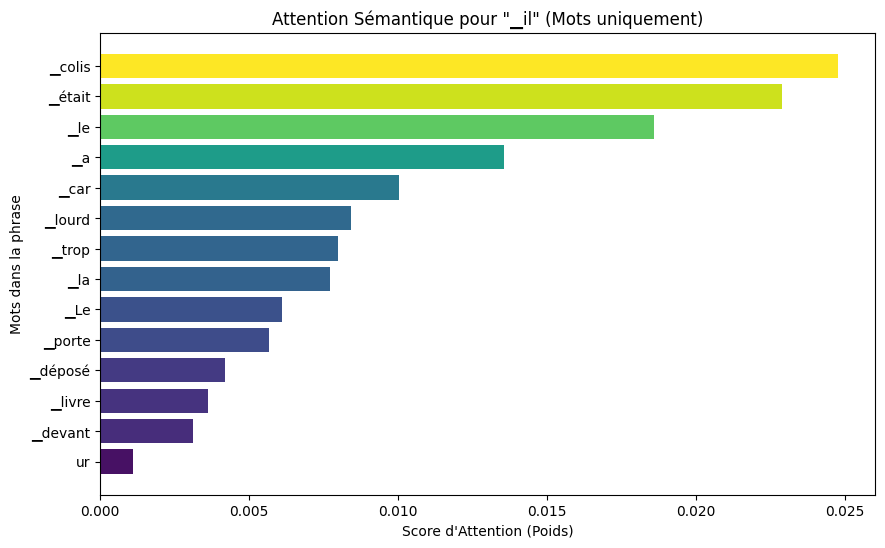

In [16]:
# -- 1. Modèle et phrase --
tokenizer = AutoTokenizer.from_pretrained("camembert-base")
model = AutoModel.from_pretrained("camembert-base", attn_implementation="eager")
text = "Le livreur a déposé le colis devant la porte, car il était trop lourd."

# -- 2. Préparation et récupération de l'attention --
encoded_input = tokenizer(text, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
with torch.no_grad():
    outputs = model(**encoded_input, output_attentions=True)
attention = outputs.attentions[-1][0].mean(dim=0)

# -- 3. On se concentre sur le pronom "il" --
token_to_find = '▁il'
token_idx = tokens.index(token_to_find)
attention_scores = attention[token_idx].numpy()
df = pd.DataFrame({'Token': tokens, 'Attention Score': attention_scores})

# -- 4. NOUVELLE ÉTAPE : On filtre les tokens non pertinents --
tokens_to_exclude = ['<s>', '</s>', '.', ',', token_to_find] # On enlève les tokens spéciaux, la ponctuation et le mot lui-même
df_filtered = df[~df['Token'].isin(tokens_to_exclude)]
df_sorted = df_filtered.sort_values('Attention Score', ascending=True)

# -- 5. On affiche le résultat filtré ! --
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(df_sorted["Attention Score"] / np.max(df_sorted["Attention Score"]))
plt.barh(df_sorted['Token'], df_sorted['Attention Score'], color=colors)
plt.title(f'Attention Sémantique pour "{token_to_find}" (Mots uniquement)')
plt.xlabel("Score d'Attention (Poids)")
plt.ylabel("Mots dans la phrase")
plt.show()


### Interprétation : comment arrive-t-on à ce résultat ?

Obtenir ce graphique clair n'est pas direct. Le résultat final est le fruit d'une démarche en trois temps qui révèle comment le modèle "pense" à différents niveaux.


#### 1. Première analyse : la vision "syntaxique" de la première couche

Si l'on regarde l'attention dans la **première couche** du modèle, le résultat est décevant. Le mot `"il"` porte son attention sur des mots proches comme `"déposé"` ou `"porte"`.

-   **Pourquoi ?** À ce stade, le modèle a une vision très locale et **syntaxique**. Il ne cherche pas encore le sens, mais plutôt à comprendre la structure grammaticale de base de la phrase.


#### 2. Deuxième analyse : la vision "structurelle" de la dernière couche

En regardant la **dernière couche**, on s'attend à voir le lien sémantique. Pourtant, le résultat est dominé par des tokens techniques :

-   `<s>` (début de phrase) et `</s>` (fin de phrase) obtiennent les scores les plus élevés.
-   Le modèle porte aussi beaucoup d'attention sur lui-même (`" il"`) et sur la ponctuation.
-   **Pourquoi ?** À la fin de son analyse, le modèle utilise ces tokens spéciaux comme des "ancres" pour consolider la structure et le contexte global de la phrase. Le lien sémantique avec `"colis"` est présent, mais noyé au milieu de ce "bruit" structurel.


#### 3. Résultat final : la vision "sémantique" en filtrant le bruit

Ce n'est qu'en **filtrant ces tokens techniques** (`<s>`, `</s>`, la ponctuation) et l'attention du mot sur lui-même que l'on isole enfin le signal purement sémantique.



Le graphique ci-dessus est donc le résultat de cette analyse finale. Il prouve que, une fois son analyse syntaxique et structurelle terminée, le modèle a bien compris que le mot le plus important pour définir `"il"` est **`"colis"`**. Cette démarche illustre parfaitement comment l'interprétation des modèles d'IA nécessite de savoir où et comment regarder.

# Utiliser HuggingFace pour charger des modèles prêts à utilisation

## Choisir le bon outil : l'importance d'un modèle adapté

La puissance de Hugging Face réside dans la **diversité des modèles disponibles**. Utiliser un modèle générique n'est souvent pas suffisant. Pour obtenir des résultats précis et fiables, il est crucial de choisir un modèle qui soit non seulement adapté à la **langue** (français, anglais, etc.), mais aussi, si possible, au **domaine spécifique** de votre analyse (avis sur des produits, commentaires sur les services publics, etc.).

La démonstration ci-dessous compare deux approches :
1.  **Le modèle par défaut** : Un modèle généraliste pour l'anglais, qui tente de deviner le sens du texte français.
2.  **Un modèle spécialisé** : Un modèle (`oliviercaron/fr-camembert-spplus-sentiment`) spécifiquement entraîné pour analyser le sentiment dans des commentaires d'usagers du service public français.

Vous verrez que la pertinence des résultats change radicalement.

In [17]:
from transformers import pipeline

# 1. Charger le pipeline pour l'analyse de sentiment
analyseur = pipeline("sentiment-analysis")

# 2. Donner des phrases à analyser
phrases = [
    "Impossible de changer mon adresse de ma carte grise en ligne et la préfecture ne veut rien entendre car ce n'est plus de son ressort. Cela fait maintenant 4 mois.",
    "I can’t change the address on my vehicle registration certificate online, and the prefecture won’t do anything about it since it’s no longer their responsibility. It’s been 4 months now."
]

# 3. Obtenir les résultats
resultats = analyseur(phrases)
print("\n".join(map(str, resultats)))


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


{'label': 'NEGATIVE', 'score': 0.9783998727798462}
{'label': 'NEGATIVE', 'score': 0.9992008805274963}


## On charge spécifiquement un modèle entraîné sur le français (usagers du service public)

Les données : https://www.data.gouv.fr/datasets/liste-des-experiences-partagees-par-les-usagers/

Le modèle : https://huggingface.co/oliviercaron/fr-camembert-spplus-sentiment

Espace HuggingFace : https://huggingface.co/spaces/oliviercaron/analyse-sentiment-sp-plus

In [16]:
# Initialize the sentiment analysis pipeline
classifier = pipeline(
    "text-classification",
    model="oliviercaron/fr-camembert-spplus-sentiment",
    device_map="auto",
    top_k=None  # Return scores for all classes
)

# Example texts
texts = [
    "Impossible de changer mon adresse de ma carte grise en ligne et la préfecture ne veut rien entendre car ce n'est plus de son ressort. Cela fait maintenant 4 mois.",
    "I can’t change the address on my vehicle registration certificate online, and the prefecture won’t do anything about it since it’s no longer their responsibility. It’s been 4 months now."
]

# Get predictions
results = classifier(texts)

print("\n".join(map(str, results)))

Device set to use cuda:0


[{'label': 'Négatif', 'score': 0.9821749329566956}, {'label': 'Neutre', 'score': 0.016635430976748466}, {'label': 'Positif', 'score': 0.0011895388597622514}]
[{'label': 'Négatif', 'score': 0.8914580941200256}, {'label': 'Neutre', 'score': 0.09904821962118149}, {'label': 'Positif', 'score': 0.009493766352534294}]


## Utiliser des modèles locaux (Ollama)

::: callout-note
### 1. Installer Ollama
Ollama est un outil qui permet de faire tourner des modèles de langage localement sur sa machine.  
Il est disponible pour macOS, Linux et Windows (via WSL).  
👉 [Télécharger Ollama](https://ollama.com/download)

:::

::: callout-note
### 2. Télécharger un modèle
Ollama propose plusieurs modèles (LLaMA, Gemma, Mistral, etc.). Ici on télécharge et charge le modèle gemma3:4b
Pour en télécharger un, utilisez la commande :

`ollama pull gemma3:4b`

Cela télécharge le modèle `gemma3:4b`.  
Vous pouvez ensuite voir les modèles disponibles localement avec :

`ollama list`

::: callout-note
### 3. Lancer une requête simple
Une fois le modèle installé, vous pouvez le tester directement dans le terminal :

`ollama run gemma3:4b`

::: callout-note
### 4. Utiliser Ollama en Python
Ollama fournit une API locale que l’on peut interroger via le package `ollama` pour Python.  
Voici un exemple minimal d’analyse de sentiment :

In [26]:
import ollama, json

texte = "Impossible de changer mon adresse de ma carte grise en ligne et la préfecture ne veut rien entendre car ce n'est plus de son ressort. Cela fait maintenant 4 mois."

prompt = f"""
Tu es un expert en analyse de sentiment.
Classe ce texte en Positif, Négatif ou Neutre.
Renvoie uniquement un JSON avec une clé : 
- "label" : la catégorie

Texte : "{texte}"
"""

try:
    response = ollama.chat(
        model="gemma3:4b",  # change selon le modèle installé
        messages=[{"role": "user", "content": prompt}],
        format="json"
    )
    
    result = json.loads(response["message"]["content"])
    print("Texte :", texte)
    print("Résultat :", result)

except Exception as e:
    print("Erreur :", e)
    print("Vérifie qu'Ollama tourne et que le modèle est bien installé.")


Texte : Impossible de changer mon adresse de ma carte grise en ligne et la préfecture ne veut rien entendre car ce n'est plus de son ressort. Cela fait maintenant 4 mois.
Résultat : {'label': 'Négatif'}


## Un exemple marketing

In [ ]:
import ollama
import json

# 1. Définir des avis clients variés (positifs, négatifs, nuancés)
avis_clients = [
    "La livraison a été ultra rapide et le produit est de très bonne qualité. Je recommande vivement !",
    "Très déçu. L'article est arrivé cassé et le service client ne répond pas à mes emails depuis une semaine.",
    "Le design est sympa, mais l'autonomie de la batterie est vraiment trop faible pour mon usage quotidien.",
    "Ce service client est d'une lenteur absolument remarquable... J'attends ma réponse depuis seulement trois semaines.",
    "Bon produit dans l'ensemble, fait ce qu'on lui demande. Rien d'exceptionnel mais pas de mauvaise surprise."
]

# 2. Convertir la liste d'avis en une seule chaîne de caractères formatée
texte_avis = "\n- ".join(avis_clients)

# 3. Créer un prompt précis pour guider le modèle
prompt = f"""
Tu es un expert en analyse marketing, spécialisé dans la voix du client.
Ta mission est de synthétiser les avis suivants pour en extraire les informations les plus pertinentes.

Voici les avis :
- {texte_avis}

Analyse ces commentaires et identifie :
1. Les 3 points forts principaux mentionnés par les clients.
2. Les 3 points faibles récurrents ou les plus importants.

Ne te contente pas de citer les avis, mais reformule les points de manière synthétique.
Réponds **uniquement** en format JSON avec les clés "points_forts" et "points_faibles".
"""

print("--- Analyse de la Voix du Client (VoC) avec un LLM ---")
print("\nAvis à analyser :")
for avis in avis_clients:
    print(f"- {avis}")
print("-" * 20)


# 4. Appeler l'API Ollama et gérer les erreurs potentielles
try:
    response = ollama.chat(
        model="gemma3:4b",  # Assurez-vous que ce modèle est installé
        messages=[{"role": "user", "content": prompt}],
        format="json"  # Demander une sortie JSON directement
    )

    # 5. Charger et afficher le résultat
    resultat = json.loads(response["message"]["content"])

    print("\n✅ Synthèse marketing générée par l'IA :\n")

    if "points_forts" in resultat:
        print("Points Forts 💪:")
        for point in resultat["points_forts"]:
            print(f"- {point}")
    
    if "points_faibles" in resultat:
        print("\nPoints Faibles 📉:")
        for point in resultat["points_faibles"]:
            print(f"- {point}")

except Exception as e:
    print(f"\n❌ Erreur lors de la communication avec Ollama : {e}")
    print("Veuillez vérifier que Ollama est bien en cours d'exécution et que le modèle 'gemma3:4b' est installé.")
    print("Pour l'installer, tapez la commande : ollama pull gemma3:4b")

--- Analyse de la Voix du Client avec un LLM ---

Avis à analyser :
- La livraison a été ultra rapide et le produit est de très bonne qualité. Je recommande vivement !
- Très déçu. L'article est arrivé cassé et le service client ne répond pas à mes emails depuis une semaine.
- Le design est sympa, mais l'autonomie de la batterie est vraiment trop faible pour mon usage quotidien.
- Ce service client est d'une lenteur absolument remarquable... J'attends ma réponse depuis seulement trois semaines.
- Bon produit dans l'ensemble, fait ce qu'on lui demande. Rien d'exceptionnel mais pas de mauvaise surprise.
--------------------

✅ Synthèse marketing générée par l'IA :

Points Forts 💪:
- Livraison ultra rapide
- Qualité du produit (de bonne qualité)
- Design sympa

Points Faibles 📉:
- Service client inefficace (réponses lentes et absence de réponse)
- Autonomie de la batterie insuffisante
- Qualité générale : 'Rien d'exceptionnel' - Indique un manque de performance ou d'attentes dépassées


::: {.callout-tip title="Liste exhaustive des paramètres de génération pour Ollama"}
Pour un contrôle total sur la sortie des modèles Ollama, vous pouvez spécifier une série de paramètres via l'objet `options`. Ces réglages permettent d'ajuster tout, de la créativité à la structure des réponses. Voici la liste complète des options disponibles :

### Contrôle de la créativité (sampling)

-   **`temperature`** (ex: `0.7`)
    Règle le niveau d'aléatoire. Une valeur proche de `0` rend le modèle déterministe et factuel, tandis qu'une valeur élevée (`>1.0`) le rend plus créatif, voire chaotique. *Défaut : 0.8*.

-   **`top_k`** (ex: `40`)
    Filtre le vocabulaire aux `k` mots les plus probables avant chaque nouvelle génération. Empêche le modèle de choisir des mots trop bizarres. *Défaut : 40*.

-   **`top_p`** (ex: `0.9`)
    Filtre le vocabulaire en sélectionnant le plus petit ensemble de mots dont la probabilité cumulée atteint le seuil `p`. Alternative dynamique à `top_k`. Il est conseillé de n'utiliser que l'un des deux. *Défaut : 0.9*.

-   **`seed`** (ex: `42`)
    Définit une "graine" pour la génération aléatoire. En utilisant la même graine pour le même prompt, vous obtiendrez systématiquement la même réponse, ce qui est utile pour la reproductibilité. *Défaut : 0 (aléatoire)*.

-   **`tfs_z`** (ex: `1`)
    Active le *tail free sampling*. Cette technique supprime les mots considérés comme improbables de la "queue" de la distribution de probabilités. Une valeur de `1` désactive ce filtre. *Défaut : 1*.

### Contrôle de la répétition

-   **`repeat_penalty`** (ex: `1.1`)
    Pénalise les mots qui ont déjà été utilisés dans la réponse, réduisant ainsi les répétitions. Une valeur supérieure à `1` augmente la pénalité. *Défaut : 1.1*.

-   **`repeat_last_n`** (ex: `64`)
    Définit sur combien de mots précédents la pénalité de répétition doit s'appliquer. Une valeur de `-1` l'applique sur toute la fenêtre de contexte. *Défaut : 64*.

### Contrôle de la longueur et de l'arrêt

-   **`num_predict`** (ex: `128`)
    Le nombre maximum de mots (tokens) à générer. Une valeur de `-1` signifie une génération illimitée jusqu'à l'arrêt naturel ou la fin du contexte. *Défaut : 128*.

-   **`stop`** (ex: `["\n", "User:"]`)
    Une liste de chaînes de caractères qui, si elles sont générées, arrêteront immédiatement la réponse. Utile pour contrôler le format de sortie (ex: arrêter après un saut de ligne).

### Contrôle du contexte

-   **`num_ctx`** (ex: `2048`)
    Définit la taille de la fenêtre de contexte (en nombre de tokens) que le modèle prendra en compte pour générer sa réponse. *Défaut : 2048*.

### Méthodes de sampling avancées (mirostat)

Mirostat est un algorithme qui ajuste dynamiquement le taux de surprise (perplexité) des réponses pour maintenir une certaine cohérence.

-   **`mirostat`** (ex: `1`)
    Active mirostat. `0` = désactivé, `1` = mirostat v1, `2` = mirostat v2. *Défaut : 0*.

-   **`mirostat_tau`** (ex: `5.0`)
    Le "taux de surprise" cible. Influence la cohérence du texte. Des valeurs plus faibles donnent un texte plus cohérent. *Défaut : 5.0*.

-   **`mirostat_eta`** (ex: `0.1`)
    Le "taux d'apprentissage". Détermine la vitesse à laquelle l'algorithme s'ajuste pour atteindre le `taux de surprise` cible. *Défaut : 0.1*.

:::

````python
# Exemple de code combinant plusieurs paramètres pour une tâche spécifique
response = ollama.chat(
    model="gemma3:4b",
    messages=[{'role': 'user', 'content': 'Raconte une très courte histoire.'}],
    options={
        'seed': 101,
        'temperature': 0.9,
        'top_k': 50,
        'repeat_penalty': 1.2,
        'num_predict': 100,
        'stop': ['.'] 
    }
)
print(response['message']['content'])

In [32]:
# Exemple d'utilisation des options pour une réponse plus factuelle
response = ollama.chat(
    model="gemma3:4b",
    messages=[{'role': 'user', 'content': 'Explique ce que sont les 4P en marketing. Développe bien'}],
    options={
        'temperature': 0.3,
        'top_k': 20
    }
)

print(response['message']['content'])

Les 4P du marketing, souvent appelés le "mix marketing", sont un cadre conceptuel fondamental utilisé par les marketeurs pour élaborer et mettre en œuvre une stratégie marketing efficace. Elles représentent les quatre éléments clés qui doivent être harmonisés pour atteindre les objectifs de l'entreprise. Ces 4P sont :

**1. Produit (Product)**

*   **Définition:** Le produit est l'article ou le service que l'entreprise vend. Il peut s'agir d'un bien physique (une voiture, un vêtement) ou d'un service (une consultation, un abonnement).
*   **Ce qu'il faut prendre en compte :**
    *   **Caractéristiques:** Quelles sont les caractéristiques physiques du produit ? (taille, couleur, matériaux, fonctionnalités)
    *   **Avantages:** Quels sont les avantages que le produit offre aux clients ? (résolution de problèmes, amélioration de la vie, statut social)
    *   **Qualité:** Quel est le niveau de qualité du produit ? (durabilité, fiabilité, performance)
    *   **Design:** Comment le prod